In [1]:
import gpflow
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ''

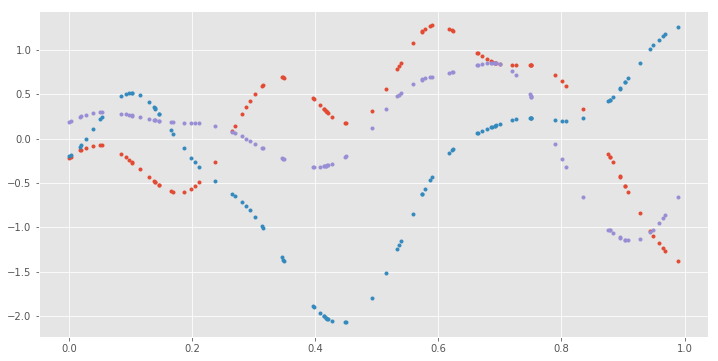

In [2]:
np.random.seed(1)
X = np.random.rand(100,1)
K = np.exp(-0.5*np.square(X - X.T)/0.01) + np.eye(100)*1e-6
f = np.dot(np.linalg.cholesky(K), np.random.randn(100,3))
plt.figure(figsize=(12,6))
plt.plot(X, f, '.')
Y = np.array(np.argmax(f, 1).reshape(-1,1), dtype=float)

In [3]:
f.shape

(100, 3)

In [4]:
m = gpflow.models.SVGP(
    X, Y, kern=gpflow.kernels.Matern32(1) + gpflow.kernels.White(1, variance=0.01),
    likelihood=gpflow.likelihoods.MultiClass(3),
    Z=X[::5].copy(), num_latent=3, whiten=True, q_diag=True)
m.kern.white.variance.trainable = False
m.feature.trainable = False
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/q_mu,Parameter,None,(none),True,"(20, 3)",True,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."
SVGP/feature/Z,Parameter,None,(none),False,"(20, 1)",True,"[[0.417022004703], [0.0923385947688], [0.41919..."
SVGP/kern/white/variance,Parameter,None,+ve,False,(),True,0.01
SVGP/kern/matern32/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/matern32/lengthscales,Parameter,None,+ve,True,(),True,1.0
SVGP/q_sqrt,Parameter,None,+ve,True,"(20, 3)",True,"[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, ..."


In [5]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.774954
  Number of iterations: 180
  Number of functions evaluations: 213


In [6]:
def plot(m):
    f = plt.figure(figsize=(12,6))
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])


    xx = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 200).reshape(-1,1)
    mu, var = m.predict_f(xx)
    mu, var = mu.copy(), var.copy()
    print(mu.shape)
    p, _ = m.predict_y(xx)

    a3.set_xticks([])
    a3.set_yticks([])


    a3.set_xticks([])
    a3.set_yticks([])

    #for i in range(m.likelihood.num_classes):
    for i in range(mu.shape[1]):
        x = m.X.read_value()[m.Y.read_value().flatten()==i]
        points, = a3.plot(x, x*0, '.')
        color=points.get_color()
        a1.plot(xx, mu[:,i], color=color, lw=2)
        a1.plot(xx, mu[:,i] + 2*np.sqrt(var[:,i]), '--', color=color)
        a1.plot(xx, mu[:,i] - 2*np.sqrt(var[:,i]), '--', color=color)
        a2.plot(xx, p[:,i], '-', color=color, lw=2)

    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])

(200, 3)


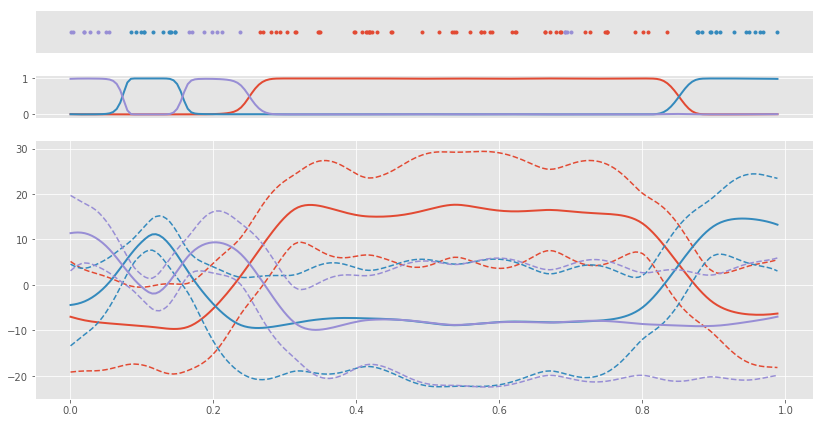

In [7]:
plot(m)

In [8]:
m.kern.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/white/variance,Parameter,None,+ve,False,(),True,0.01
SVGP/kern/matern32/variance,Parameter,None,+ve,True,(),True,80.3457819920494
SVGP/kern/matern32/lengthscales,Parameter,None,+ve,True,(),True,0.10404091085864153


In [9]:
import keras
from keras.datasets import mnist

xs_train_full = np.genfromtxt("../data/mnist_train_features.csv", delimiter=",")
xs_test_full = np.genfromtxt("../data/mnist_test_features.csv", delimiter=",")

def get_mnist_classes():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)
    return (y_train, y_test)

ys_train_full, ys_test_full = get_mnist_classes()

def _filter(xs, ys, limit_features = 2, limit_classes = 2):
    print("Filtering xs and ys to ", limit_features, " features and ", limit_classes, " classes")
    # note ys are expected to be 1-hot encoded

    # TODO rewrite this more numpy-esque
    filtered_xs = [[] for i in range(limit_classes)]
    filtered_ys = [[] for i in range(limit_classes)]
    for (x,y) in zip(xs, ys):
        for i in range(limit_classes):
            one_hot_class = keras.utils.to_categorical(i, ys.shape[-1])[0]
            if np.array_equal(y, one_hot_class):
                filtered_xs[i].append(x[:limit_features])
                filtered_ys[i].append(y[:limit_classes])
                break


    filtered_xs = [np.array(x) for x in  filtered_xs]
    filtered_ys = [np.array(x) for x in  filtered_ys]
    # collapse the per-class matrices into one big matrix
    return (np.vstack(filtered_xs), np.vstack(filtered_ys))


Using TensorFlow backend.


Filtering xs and ys to  1  features and  5  classes


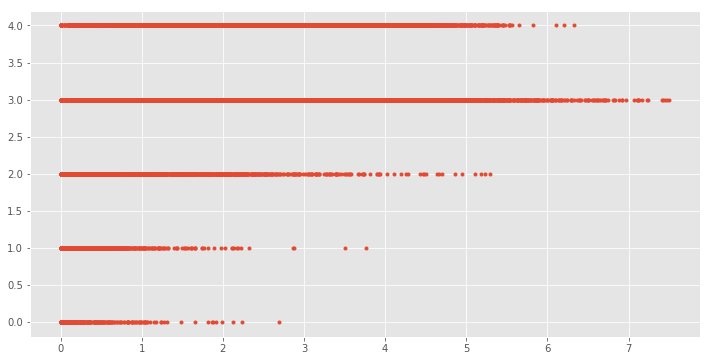

In [10]:
num_classes = 5
xs_train, ys_train = _filter(xs_train_full, ys_train_full, 1, num_classes)
plt.figure(figsize=(12,6))
plt.plot(xs_train, np.argmax(ys_train, axis=1), '.')

In [11]:
# m2 = gpflow.models.SVGP(
#     xs_train, np.argmax(ys_train, axis=1), kern=gpflow.kernels.Matern32(1) + gpflow.kernels.White(1, variance=0.01),
#     likelihood=gpflow.likelihoods.MultiClass(num_classes),
#     Z=xs_train[::50].copy(), num_latent=num_classes, whiten=True, q_diag=True)
# m2.kern.white.variance.trainable = False
# m2.feature.trainable = False
# m2.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/q_mu,Parameter,None,(none),True,"(612, 5)",True,"[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."
SVGP/feature/Z,Parameter,None,(none),False,"(612, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVGP/kern/white/variance,Parameter,None,+ve,False,(),True,0.01
SVGP/kern/matern32/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/matern32/lengthscales,Parameter,None,+ve,True,(),True,1.0
SVGP/q_sqrt,Parameter,None,+ve,True,"(612, 5)",True,"[[1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1...."


In [12]:
# opt = gpflow.train.ScipyOptimizer()
# opt.minimize(m2)

KeyboardInterrupt: 

In [ ]:
# plot(m2)
# m2.as_pandas_table()

In [13]:
# try fitting entirety of model
num_features = xs_train_full.shape[-1]
num_classes = 10
print("Using", num_features, "features, predicting", num_classes, "classes")

ys = np.argmax(ys_train_full, axis=1)
print(xs_train_full)
print(ys)

full_model = gpflow.models.SVGP(
    xs_train_full, ys, kern=gpflow.kernels.Matern32(input_dim=num_features) + gpflow.kernels.White(input_dim=num_features, variance=0.2),
    likelihood=gpflow.likelihoods.MultiClass(num_classes),
    Z=xs_train_full[::40].copy(), 
    num_latent=num_classes, 
    whiten=True, 
    q_diag=True,
    minibatch_size=5000)
full_model.kern.white.variance.trainable = False
full_model.feature.trainable = False
full_model.as_pandas_table()

Using 128 features, predicting 10 classes
[[ 3.77484059  0.          2.92459512 ...,  0.          0.          0.21612643]
 [ 0.          0.          1.85677981 ...,  3.52286148  0.          2.25188851]
 [ 1.31674075  0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 3.01320338  0.          4.24100637 ...,  0.          0.          0.        ]
 [ 2.53104782  1.11825061  0.         ...,  0.          2.1722796   0.        ]
 [ 0.          0.85783982  0.         ...,  0.          0.          3.26746249]]
[5 0 4 ..., 5 6 8]


,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/q_mu,Parameter,None,(none),True,"(1500, 10)",True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
SVGP/feature/Z,Parameter,None,(none),False,"(1500, 128)",True,"[[3.77484059334, 0.0, 2.92459511757, 0.0, 3.72..."
SVGP/kern/white/variance,Parameter,None,+ve,False,(),True,0.2
SVGP/kern/matern32/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/matern32/lengthscales,Parameter,None,+ve,True,(),True,1.0
SVGP/q_sqrt,Parameter,None,+ve,True,"(1500, 10)",True,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


In [14]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(full_model)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 6761.897608
  Number of iterations: 16
  Number of functions evaluations: 29


In [15]:
y = full_model.predict_y(xs_test_full)

In [16]:
mu = y[0]
var = y[1]
print(mu)

[[  1.13991582e-04   1.11111112e-04   1.19443080e-04 ...,   9.98101360e-01
    1.20762848e-04   1.45100740e-04]
 [  2.34486585e-04   1.24472179e-04   9.97971587e-01 ...,   1.13943578e-04
    1.21224228e-04   1.16496786e-04]
 [  1.14576719e-04   9.98101360e-01   1.12722434e-04 ...,   1.11864903e-04
    1.11748538e-04   1.11502748e-04]
 ..., 
 [  1.12626055e-04   1.11148104e-04   1.14539580e-04 ...,   1.32686009e-04
    1.47276413e-04   1.15172359e-04]
 [  1.17649742e-04   1.25963780e-04   1.12513765e-04 ...,   1.14301425e-04
    1.44689017e-04   1.12564800e-04]
 [  1.22687423e-04   1.11752136e-04   1.33010282e-04 ...,   1.12443815e-04
    1.20101498e-04   1.13637528e-04]]


In [17]:
print(mu[1], var[1])

[  2.34486585e-04   1.24472179e-04   9.97971587e-01   1.27521188e-04
   1.30249495e-04   1.22684351e-04   1.38515877e-04   1.13943578e-04
   1.21224228e-04   1.16496786e-04] [ 0.00023443  0.00012446  0.0020243   0.0001275   0.00013023  0.00012267
  0.0001385   0.00011393  0.00012121  0.00011648]


In [18]:
def plot_instances(correct_class, mus, vars, width=0.3):
    n = mus.shape[0]
    classes = np.arange(mus.shape[-1])
    w = 3
    h = int(n/w) + 1    
    fig = plt.figure(figsize=(20,40*w))

    for i in range(n):
        mu = mus[i]
        var = vars[i]
        ax = fig.add_subplot(h, w, i+1)
        rects1 = ax.bar(classes, mu, width, color='r', yerr=var)
        rects2 = ax.bar(correct_class[i], mu[correct_class[i]], width, color='g', yerr=var[correct_class[i]])
        ax.set_xticks(classes)


In [19]:
predicted_classes = np.argmax(mu, axis=1)
correct_classes = np.argmax(ys_test_full, axis=1)

In [20]:
print(predicted_classes)
print(correct_classes)

[7 2 1 ..., 4 5 6]
[7 2 1 ..., 4 5 6]


In [21]:
mask = predicted_classes != correct_classes
incorrect_indices = np.nonzero(mask)[0]

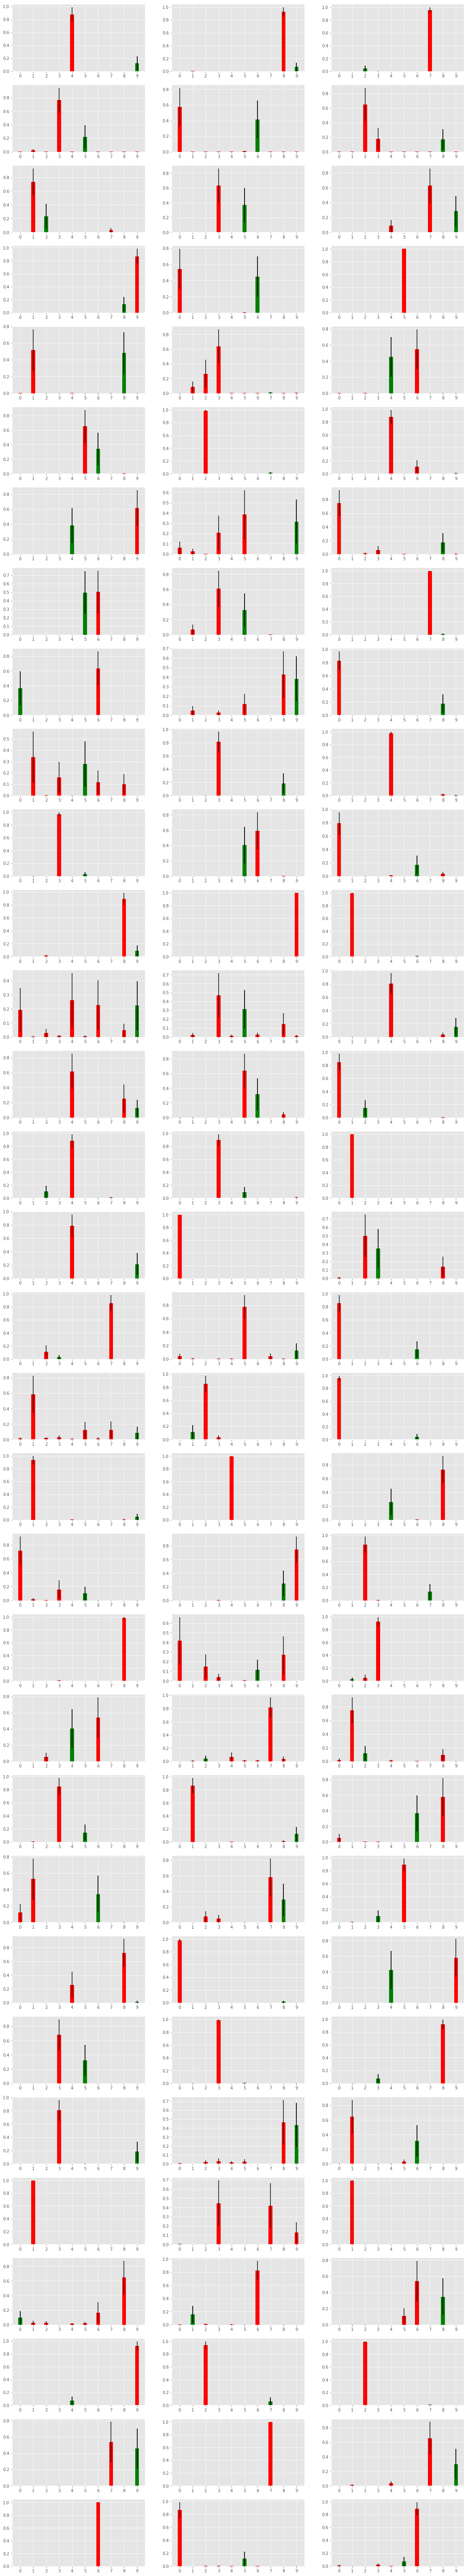

In [22]:
plot_instances(correct_classes[mask], mu[mask], var[mask])

In [143]:
def make_histogram(values, start=0.0, end=None, bins=10, plot=True, color='r', width=None):
    if end is None:
        max_value = values.max()
    else:
        max_value = end
    if width is None:
        plt.hist(values, bins, range=(start, max_value), color=color)
    else:
        plt.hist(values, bins, range=(start, max_value), color=color, width=width)
    if plot:
        plt.show()

In [144]:
cnn_train_output = np.genfromtxt("../data/mnist_train_cnn_output.csv", delimiter=",")
cnn_test_output = np.genfromtxt("../data/mnist_test_cnn_output.csv", delimiter=",")

[ 0.90331048  0.50962085  0.89131516  0.96917677  0.98712838  0.86262989
  0.8931365   0.32015684  0.55975604  0.69733238  0.89649504  0.47877976
  0.96951306  0.67756796  0.40853724  0.98490661  0.92028916  0.55201101
  0.58195996  0.99035245  0.68117052  0.38105091  0.26633018  0.76685452
  0.80956078  0.50034189  0.30286437  0.74878436  0.01141022  0.98942167
  0.55372435  0.53163242  0.98581785  0.60648233  0.81093949  0.54595816
  0.98190707  0.99998498  0.85221952  0.97004414  0.69256592  0.33269933
  0.99922466  0.33643478  0.96774095  0.94874835  0.41368446  0.99184084
  0.66895992  0.76194686  0.99985576  0.19486851  0.4777588   0.12072045
  0.05180589  0.58093953  0.97830862  0.97971183  0.96523017  0.84908968
  0.98028183  0.99594337  0.65477395  0.75955886  0.2084249   0.31098488
  0.9946906   0.35272592  0.90525806  0.99963975  0.61641431  0.63674641
  0.68270165  0.29880241  0.51349282  0.77319634  0.57426888  0.21741168
  0.91966659  0.7586053   0.3531369   0.97913408  0

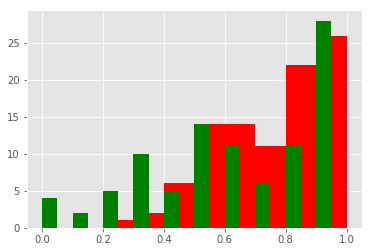

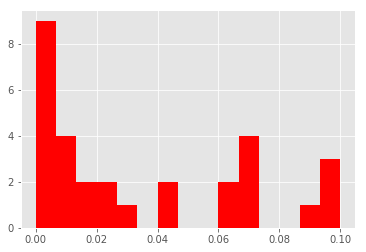

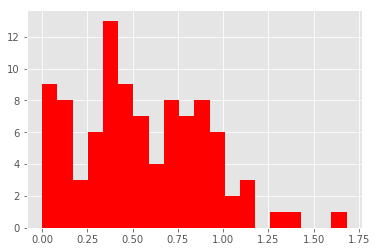

In [203]:
all_incorrect_mus = np.array([])
all_incorrect_vars = np.array([])

cnn_output = []

for cat in range(10):
    # get all examples that actually belong to this category
    cat_examples = correct_classes == cat
    # extract the subset of that digit that were incorrectly classified
    cat_incorrect_examples = cat_examples & mask 
    incorrectly_classified_mus = mu[cat_incorrect_examples]
    incorrectly_classified_vars = var[cat_incorrect_examples]
    
    corresponding_cnn_output = cnn_test_output[cat_incorrect_examples]
    
    # which ones were predicted (all incorrect)
    predicted_classes = np.argmax(mu[cat_incorrect_examples], axis=1)
    
    #print(predicted_classes)
    # extract the corresponding values into an array
    incorrect_prediction_mus, incorrect_prediction_vars = [], []
    for (i, c) in enumerate(predicted_classes):
        incorrect_prediction_mus.append(incorrectly_classified_mus[i, c])
        incorrect_prediction_vars.append(incorrectly_classified_vars[i, c])
        
        cnn_output.append(corresponding_cnn_output[i, c])

    incorrect_prediction_mus = np.array(incorrect_prediction_mus)
    incorrect_prediction_vars = np.array(incorrect_prediction_vars)

    
    all_incorrect_mus = np.append(all_incorrect_mus, incorrect_prediction_mus)
    all_incorrect_vars = np.append(all_incorrect_vars, incorrect_prediction_vars)
    
#     incorrect_mus = mu[cat_incorrect_examples, cat]
#     incorrect_vars = var[cat_incorrect_examples,cat]
#     all_incorrect_mus = np.append(all_incorrect_mus, incorrect_mus)
#     all_incorrect_vars = np.append(all_incorrect_vars, incorrect_vars)
#     make_histogram(incorrect_vars)
    #make_histogram(incorrect_mus)
cnn_output = np.array(cnn_output)
print(cnn_output)
print(all_incorrect_mus)
print(all_incorrect_vars)

variance_normalized_by_probability = np.sqrt(all_incorrect_vars)/all_incorrect_mus

print(variance_normalized_by_probability)

make_histogram(all_incorrect_mus, end = 1.0, plot=False, width=0.1)
make_histogram(cnn_output, end = 1.0, plot=True, color='g', width=0.05)

make_histogram(all_incorrect_vars, bins=15, end=0.1)
make_histogram(variance_normalized_by_probability, bins=20)

[ 0.90331048  0.50962085  0.89131516  0.96917677  0.98712838  0.86262989
  0.8931365   0.32015684  0.55975604  0.69733238  0.89649504  0.47877976
  0.96951306  0.67756796  0.40853724  0.98490661  0.92028916  0.55201101
  0.58195996  0.99035245  0.68117052  0.38105091  0.26633018  0.76685452
  0.80956078  0.50034189  0.30286437  0.74878436  0.01141022  0.98942167
  0.55372435  0.53163242  0.98581785  0.60648233  0.81093949  0.54595816
  0.98190707  0.99998498  0.85221952  0.97004414  0.69256592  0.33269933
  0.99922466  0.33643478  0.96774095  0.94874835  0.41368446  0.99184084
  0.66895992  0.76194686  0.99985576  0.19486851  0.4777588   0.12072045
  0.05180589  0.58093953  0.97830862  0.97971183  0.96523017  0.84908968
  0.98028183  0.99594337  0.65477395  0.75955886  0.2084249   0.31098488
  0.9946906   0.35272592  0.90525806  0.99963975  0.61641431  0.63674641
  0.68270165  0.29880241  0.51349282  0.77319634  0.57426888  0.21741168
  0.91966659  0.7586053   0.3531369   0.97913408  0

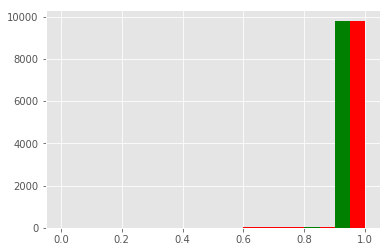

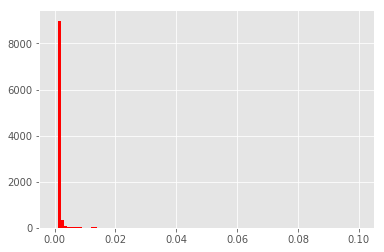

In [173]:
all_correct_mus = np.array([])
all_correct_vars = np.array([])

cnn_output_correct = []

for cat in range(10):
    # get all examples that actually belong to this category
    cat_examples = correct_classes == cat
    # extract the subset of that digit that were incorrectly classified
    cat_correct_examples = cat_examples & ~mask 
    correctly_classified_mus = mu[cat_correct_examples]
    correctly_classified_vars = var[cat_correct_examples]
    
    corresponding_cnn_output = cnn_test_output[cat_correct_examples]
    
    # which ones were predicted (all incorrect)
    predicted_classes = np.argmax(mu[cat_correct_examples], axis=1)
    
    #print(predicted_classes)
    # extract the corresponding values into an array
    correct_prediction_mus, correct_prediction_vars = [], []
    for (i, c) in enumerate(predicted_classes):
        correct_prediction_mus.append(correctly_classified_mus[i, c])
        correct_prediction_vars.append(correctly_classified_vars[i, c])
        
        cnn_output_correct.append(corresponding_cnn_output[i, c])

    correct_prediction_mus = np.array(correct_prediction_mus)
    correct_prediction_vars = np.array(correct_prediction_vars)

    
    all_correct_mus = np.append(all_correct_mus, correct_prediction_mus)
    all_correct_vars = np.append(all_correct_vars, correct_prediction_vars)
    
#     incorrect_mus = mu[cat_incorrect_examples, cat]
#     incorrect_vars = var[cat_incorrect_examples,cat]
#     all_incorrect_mus = np.append(all_incorrect_mus, incorrect_mus)
#     all_incorrect_vars = np.append(all_incorrect_vars, incorrect_vars)
#     make_histogram(incorrect_vars)
    #make_histogram(incorrect_mus)
cnn_output_correct = np.array(cnn_output_correct)
print(cnn_output)
print(all_correct_mus)
print(all_correct_vars)

make_histogram(all_correct_mus, end = 1.0, plot=False, width=0.1)
make_histogram(cnn_output_correct, end = 1.0, plot=True, color='g', width=0.05)

make_histogram(all_correct_vars, bins=100, end=0.1)


In [174]:
mus_vars_correct = np.array(list(zip(all_correct_mus, all_correct_vars)))

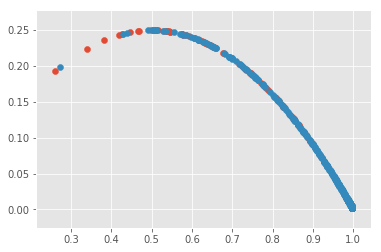

In [176]:
plt.scatter(all_incorrect_mus, all_incorrect_vars)
plt.scatter(all_correct_mus, all_correct_vars)

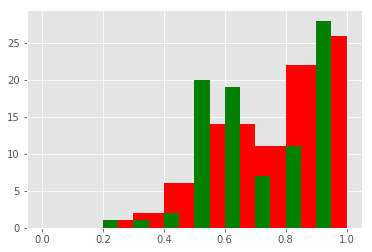

GP: mean incorrect prediction prob =  0.757790764698
GP: stddev incorrect prediction prob =  0.18770906172
GP: median incorrect prediction prob =  0.798853053382
CNN: mean incorrect prediction prob =  0.752902235543
CNN: stddev incorrect prediction prob =  0.184316559188
CNN: media incorrect prediction prob =  0.74878436327


In [201]:
# Explore the failure of the Neural Net softmax layer
cnn_predicted_classes = np.argmax(cnn_test_output, axis=1)
cnn_incorrect_predictions = cnn_predicted_classes != correct_classes

cnn_incorrect_probs = cnn_test_output[cnn_incorrect_predictions]
cnn_incorrect_true_classes = correct_classes[cnn_incorrect_predictions]
cnn_bad_predictions = np.max(cnn_incorrect_probs, axis=1)

make_histogram(all_incorrect_mus, end = 1.0, plot=False, width=0.1)
make_histogram(cnn_bad_predictions, color='g', width=0.05)
print("GP: mean incorrect prediction prob = ", np.mean(all_incorrect_mus))
print("GP: stddev incorrect prediction prob = ", np.sqrt(np.var(all_incorrect_mus)))
print("GP: median incorrect prediction prob = ", np.median(all_incorrect_mus))

print("CNN: mean incorrect prediction prob = ", np.mean(cnn_bad_predictions))
print("CNN: stddev incorrect prediction prob = ", np.sqrt(np.var(cnn_bad_predictions)))
print("CNN: media incorrect prediction prob = ", np.median(cnn_bad_predictions))


In [227]:
# Question: can we combine results from CNN _and_ GP to improve classification results?

# for each example, get both GP and CNN class predictions and prob
indices = np.argmax(mu, axis=1)
gp_predictions = []
for (i, index) in enumerate(indices):
    gp_predictions.append([index, mu[i, index]])

indices = np.argmax(cnn_test_output, axis=1)
cnn_predictions = []
for (i, index) in enumerate(indices):
    cnn_predictions.append([index, cnn_test_output[i, index]])

decision = []
for ((gp_class, gp_prob), (cnn_class, cnn_prob)) in zip(gp_predictions, cnn_predictions):
    if gp_prob >= cnn_prob:
        decision.append([0, gp_class, gp_prob]) # tag with GP source
    else:
        decision.append([1, cnn_class, cnn_prob]) # tag with CNN source
decision = np.array(decision)

In [230]:
sources = decision[:, 0]
print("GP decisions: " , np.count_nonzero(sources == 0))
print("CNN decisions: ", np.count_nonzero(sources == 1))

GP decisions:  345
CNN decisions:  9655


In [244]:
combined_decisions = decision[:, 1]
combined_incorrect = combined_decisions != correct_classes
print("Combined incorrect: ", np.count_nonzero(combined_incorrect))
print("GP-only incorrect: ", np.count_nonzero(mask))
print("CNN-only incorrect: ", np.count_nonzero(cnn_incorrect_predictions))

# TODO something wrong here, overlap CNN/Combined and Combined/GP should equal Combined incorrect!!

print("Overlap misclassified Combined vs CNN: ", np.count_nonzero(cnn_incorrect_predictions != combined_incorrect))
print("Overlap misclassified Combined vs GP: ", np.count_nonzero(mask != combined_incorrect))
print("Overlap misclassified CNN vs GP: ", np.count_nonzero(mask != cnn_incorrect_predictions))

Combined incorrect:  89
GP-only incorrect:  96
CNN-only incorrect:  89
Overlap misclassified Combined vs CNN:  18
Overlap misclassified Combined vs GP:  17
Overlap misclassified CNN vs GP:  35
